##1. Tải bộ dữ liệu:

In [29]:
!gdown --id 1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V
To: /content/NonLinear_data.npy
100% 5.57k/5.57k [00:00<00:00, 13.4MB/s]


##2. Import các thư viện cần thiết:

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

##3. Cài đặt giá trị ngẫu nhiên cố định và thiết bị tính toán:

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random_seed = 59
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

##4. Đọc bộ dữ liệu:

In [32]:
dataset_path = '/content/NonLinear_data.npy'
dataset = np.load(dataset_path, allow_pickle=True).item()
X, y = dataset['X'], dataset['labels']
print(X.shape)
print(y.shape)

(300, 2)
(300,)


##5. Chia bộ dữ liệu train/val/test:

In [33]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_seed,
    shuffle=is_shuffle
)

##6. Chuẩn hóa đặc trưng đầu vào:

In [34]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

##7. Xây dựng DataLoader:

In [35]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [36]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##8. Xây dựng mạng MLP:

In [37]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.output(x)
        return x.squeeze(1)

In [38]:
input_dim = X_train.shape[1]
output_dim = torch.unique(y_train).shape[0]
hidden_dim = 128

model = MLP(input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim).to(device)

##9. Khai báo hàm loss và optimizer:

In [39]:
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

##10. Xây dựng hàm tính độ chính xác:

In [40]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

##11. Huấn luyện mô hình:

In [41]:
epochs = 100
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    train_loss = 0.0
    train_target, val_target, train_predict, val_predict = [], [], [], []

    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_predict.append(y_pred.detach().cpu())
        train_target.append(y_batch.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_accs.append(compute_accuracy(train_predict, train_target))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            val_loss += loss.item()
            val_predict.append(y_pred.cpu())
            val_target.append(y_batch.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_accs.append(compute_accuracy(val_predict, val_target))

    print(f'Epoch {epoch + 1}/{epochs}:\ttrain_loss: {train_loss:.3f}\tval_loss: {val_loss:.3f}')

Epoch 1/100:	train_loss: 1.004	val_loss: 0.944
Epoch 2/100:	train_loss: 0.849	val_loss: 0.876
Epoch 3/100:	train_loss: 0.773	val_loss: 0.831
Epoch 4/100:	train_loss: 0.726	val_loss: 0.810
Epoch 5/100:	train_loss: 0.691	val_loss: 0.790
Epoch 6/100:	train_loss: 0.678	val_loss: 0.765
Epoch 7/100:	train_loss: 0.655	val_loss: 0.719
Epoch 8/100:	train_loss: 0.623	val_loss: 0.738
Epoch 9/100:	train_loss: 0.595	val_loss: 0.667
Epoch 10/100:	train_loss: 0.581	val_loss: 0.673
Epoch 11/100:	train_loss: 0.565	val_loss: 0.621
Epoch 12/100:	train_loss: 0.542	val_loss: 0.622
Epoch 13/100:	train_loss: 0.513	val_loss: 0.578
Epoch 14/100:	train_loss: 0.498	val_loss: 0.597
Epoch 15/100:	train_loss: 0.474	val_loss: 0.560
Epoch 16/100:	train_loss: 0.474	val_loss: 0.493
Epoch 17/100:	train_loss: 0.442	val_loss: 0.455
Epoch 18/100:	train_loss: 0.400	val_loss: 0.438
Epoch 19/100:	train_loss: 0.377	val_loss: 0.408
Epoch 20/100:	train_loss: 0.350	val_loss: 0.397
Epoch 21/100:	train_loss: 0.357	val_loss: 0.396
E

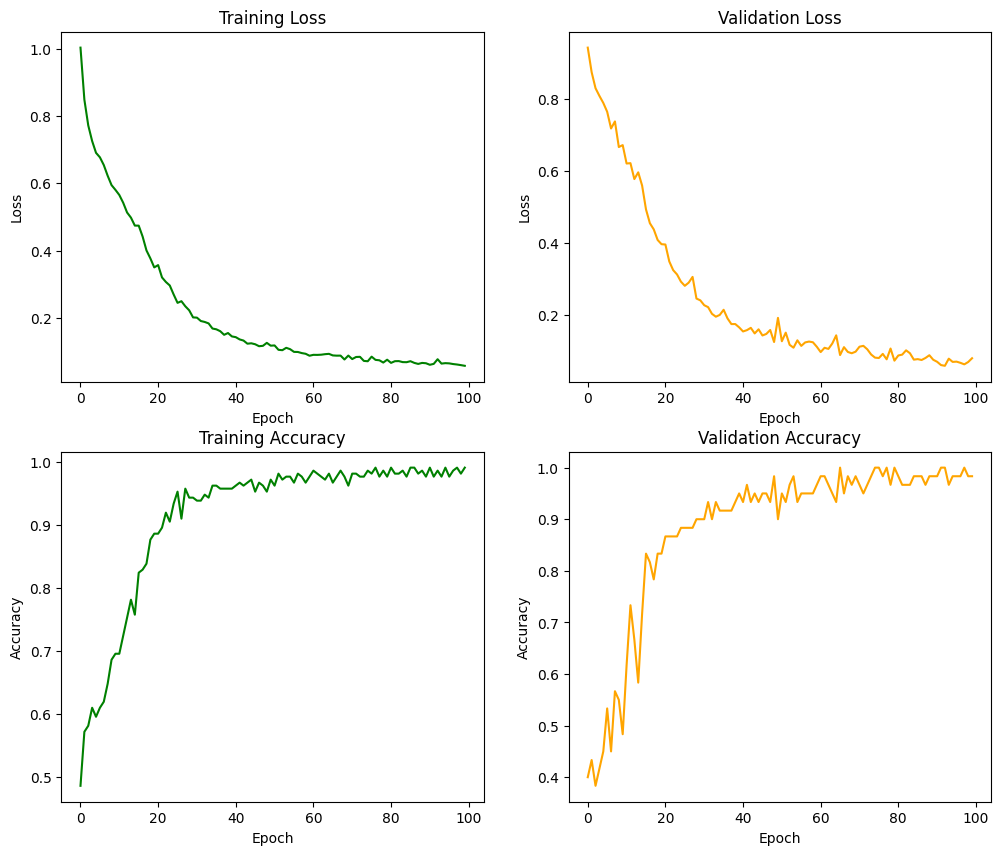

In [42]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

##12. Đánh giá mô hình:

In [43]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.9333333333333333


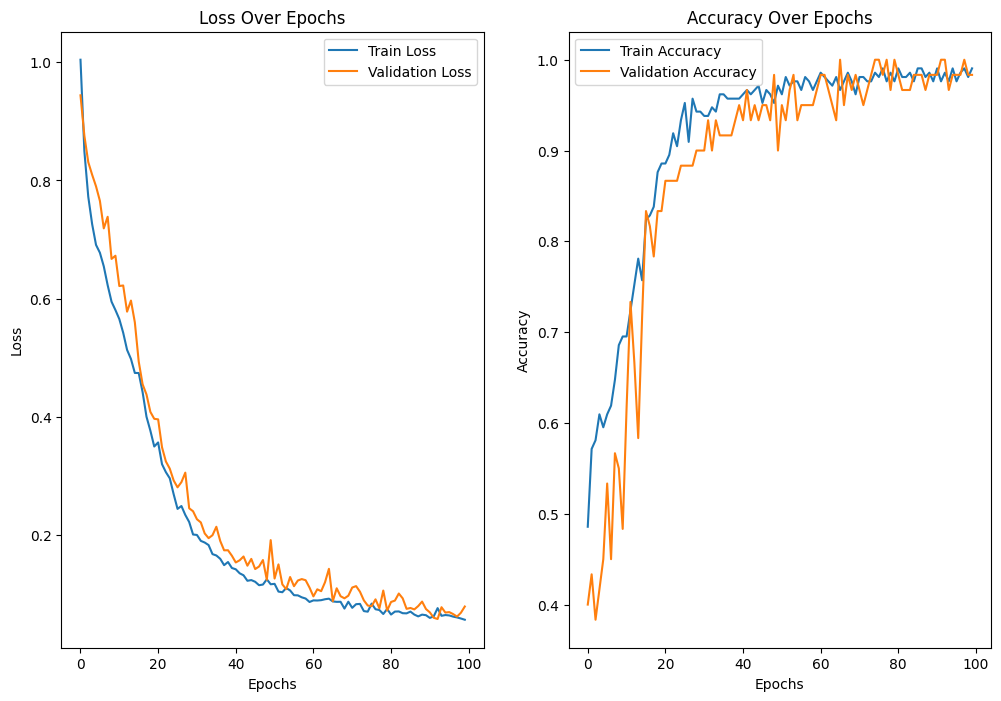

In [44]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

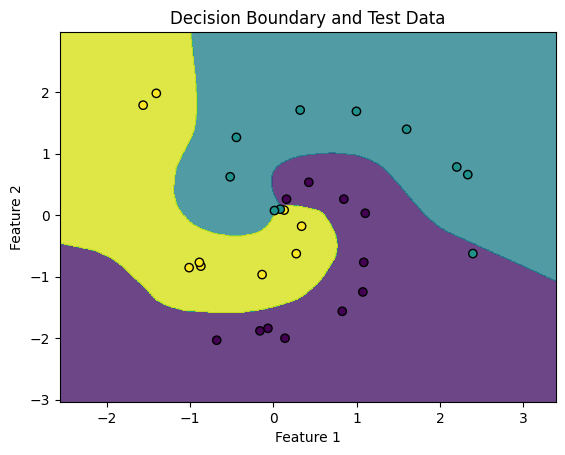

In [45]:
def plot_decision_boundary(model, X, y, device):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32).to(device)
    with torch.no_grad():
        Z = model(grid_tensor).cpu().numpy()
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary and Test Data')
    plt.show()

# Convert test data to numpy for plotting
X_test_np = X_test.cpu().numpy()
y_test_np = y_test.cpu().numpy()

# Plot the decision boundary with test data
plot_decision_boundary(model, X_test_np, y_test_np, device)